
# Vacination Forecast Germany

In [108]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import json
import requests
import matplotlib.pyplot as plt
from tabula import read_pdf
from tika import parser # pip install tika
from math import ceil, floor
from tools import get_files_from_dir, download_if_new, pd_set_options
from corona import calc_effects, vac_dist_to_1_2, vacs, vac_list, vac_list_cum, population
#from assumptions import week_delta

In [109]:
pd_set_options()
%reload_ext autoreload
%autoreload 2

### Flexible assumptions:

In [110]:
# percentage of the population for which suitable vaccines are existing. (E.g. they are old enough.)
equal_older_16 = 0.854 # source: https://www.zeit.de/wissen/gesundheit/corona-impfungen-deutschland-impfquote-impffortschritt-aktuelle-karte
# for 16 or older:
population_part_able_16 = equal_older_16 # (16 or older)
# for 12 or older:
population_part_able_12 = (1 - (1 - equal_older_16) * 12 /16) #(estimation for 12 or older / 12 ages are excluded: 0,1,...,11)
population_part_able = population_part_able_12
minimum_age_for_vac_implemented = 12 if population_part_able == population_part_able_12 else 16 if \
    population_part_able == population_part_able_12 else 'unknown' 
# percentage of these which do want a vaccination 
population_willing_of_able = 0.9

astra_biontech_cross = True
astra_moderna_cross = False

print('relativ vaccination_potential:', population_part_able * population_willing_of_able)
vaccination_potential = population * population_part_able * population_willing_of_able
print('total vaccination_potential in mln.:', round(vaccination_potential/1000000,3))
rel_vaccination_potential = population_part_able * population_willing_of_able

relativ vaccination_potential: 0.80145
total vaccination_potential in mln.: 66.6


### Adaption of table output and technical adaptions:

In [111]:
current_folder = os.getcwd()
data_folder = os.path.join(current_folder,'corona_data')
try:
    os.mkdir(data_folder)
    print('data folder created')
except:
    print('data folder already exists')
result_folder = os.path.join(current_folder,'corona_results')
try:
    os.mkdir(image_result_folder)
    print('result folder created')
except:
    print('result folder already exists')

data folder already exists
result folder already exists


### External links

In [112]:
url_vaccinations = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
url_deliveries = 'https://www.bundesgesundheitsministerium.de/fileadmin/Dateien/3_Downloads/C/Coronavirus/Impfstoff/Lieferprognosen_aller_Hersteller_2._Quartal.pdf'

### Downloading files
(including check if the files are new, if not they are deleted directly)

In [116]:
file_path_vaccinations = download_if_new(url_vaccinations,data_folder)
file_path_deliveries = download_if_new(url_deliveries,data_folder,n_th_last_file=0)
print('last date in vaccination file status:                      ',dt.datetime.strptime(pd.read_csv(file_path_vaccinations,sep='\t')['date'].iloc[-1],'%Y-%m-%d').strftime('%d.%m.%y'))
print(file_path_deliveries)
raw = parser.from_file(file_path_deliveries)
print('Delivery file status (out of "metadata": "Last-Modified"): ',dt.datetime.strptime(raw['metadata']['Last-Modified'], '%Y-%m-%dT%H:%M:%SZ').strftime('%d.%m.%y %H:%M'))
print('Delivery file status (out of the pdf-text):                ', raw['content'][raw['content'].find('Stand'):raw['content'].find('2021')+4])

The-file germany_vaccinations_timeseries_v2.tsv is not updated
The-file Lieferprognosen_aller_Hersteller_2._Quartal.pdf is not updated
last date in vaccination file status:                       04.07.21
/home/thomas/Dropbox/git/a.my.stuff/corona_vaccination_effect_predictor/corona_data/210703 103804_Lieferprognosen_aller_Hersteller_2._Quartal.pdf
Delivery file status (out of "metadata": "Last-Modified"):  02.07.21 07:21
Delivery file status (out of the pdf-text):                 Stand 2. Juli 2021


### Preparing csv-data - Vaccinations already done

In [115]:
df = pd.read_csv(file_path_vaccinations,sep='\t')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.rename(columns={'dosen_biontech_erst_kumulativ':'biontech_1_cum','dosen_biontech_zweit_kumulativ':'biontech_2_cum'
                  ,'dosen_moderna_erst_kumulativ':'moderna_1_cum','dosen_moderna_zweit_kumulativ':'moderna_2_cum'
                  ,'dosen_astrazeneca_erst_kumulativ':'astrazeneca_1_cum','dosen_astrazeneca_zweit_kumulativ':'astrazeneca_2_cum'
                  ,'dosen_johnson_kumulativ':'johnson_1_cum'
                  ,'personen_erst_kumulativ': 'all_1','personen_voll_kumulativ': 'all_full'},inplace=True)
columns_begin = ['date','biontech_1_cum','biontech_2_cum','moderna_1_cum','moderna_2_cum','astrazeneca_1_cum','astrazeneca_2_cum'
                 ,'johnson_1_cum','all_1','all_full']
df['week']= df['date'].apply(lambda x: x.isocalendar()[1])
df['weekday']= df['date'].apply(lambda x: x.isocalendar()[2])

df_total = df[[c for c in columns_begin] + [c for c in df if c not in columns_begin]]

df = df_total[['date','week','weekday']+vac_list_cum[:-1]+['all_1','all_full']].copy()
df = calc_effects(df,shift = 14)

print('Doses last day / 7 and / 14 days more early:    ', df['date'].iloc[-1].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-1]/1000000,3), '   ',\
    df['date'].iloc[-8].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-8]/1000000,3), '   ',\
    df['date'].iloc[-15].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-15]/1000000,3))
print('Doses 2nd last day / 7 and / 14 days more early:', df['date'].iloc[-2].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-2]/1000000,3), '   ',\
    df['date'].iloc[-9].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-9]/1000000,3), '   ',\
    df['date'].iloc[-16].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-16]/1000000,3))
print('Total doses:', round(df_total['dosen_kumulativ'].iloc[-1]/1000000,3))

print('1st dose: ',round(df['all_1'].iloc[-1]/1000000,3),'mln')
print('Full dose: ',round(df['all_full'].iloc[-1]/1000000,3),'mln')
print('1st dose working: ',round(df['all_1'].iloc[-15]/1000000,3),'mln')
print('Full dose working: ',round(df['all_full'].iloc[-15]/1000000,3),'mln')
print('1st dose last week: ',round((df['all_1'].iloc[-1] - df['all_1'].iloc[-8])/1000000,3),'mln')
print('Full dose last week: ',round((df['all_full'].iloc[-1] - df['all_full'].iloc[-8])/1000000,3),'mln')

print('Doses last week: ',round((df_total['dosen_kumulativ'].iloc[-1] - df_total['dosen_kumulativ'].iloc[-8])/1000000,3),'mln')
#print('Doses last week: ',round((df_total['dosen_kumulativ'].iloc[-1] - df_total['dosen_kumulativ'].iloc[-8])/1000000,3),'mln')
print('Doses 2nd-last week: ',round((df_total['dosen_kumulativ'].iloc[-8] 
                                     - df_total['dosen_kumulativ'].iloc[-15])/1000000,3),'mln')

print()

rel_net_effect = round(df['net_effect'].iloc[-1] / df['all_1'].iloc[-1],3)
print(f'The current net effect per person with current 1st dose is {rel_net_effect}')
rel_net_effect_2nd = round(df['net_effect_2nd'].iloc[-1] / df['all_full'].iloc[-1],3)
print(f'The current net effect per person with current 2nd dose is {rel_net_effect_2nd}')
current_real_net = round(df['rel_net_effect'].iloc[-1],3)
print(f'The current relative net effect on the population is ',current_real_net)
R_to_1 = round(1 / (1-current_real_net),3)
print(f'A R-rate of {R_to_1} is reduced to one due to the vaccination')
real_net_14 = round(df['rel_net_effect_after_14'].iloc[-1],3)
print(f'The relative net effect in 14 days on the population is ',real_net_14)
R_to_1_14 = round(1 / (1-real_net_14),3)
print(f'In 14 days a R-rate of {R_to_1_14} is reduced to 1.0 due to the vaccination')
                                            
#df.iloc[-10:,:]
df['new_total_mln'] = df['rel_new_total'] * population / 1000000
df[['date','week','rel_new_1st','rel_new_full','rel_new_total','new_total_mln','rel_all_1','rel_all_full','rel_net_effect','R_to_1','rel_net_effect_after_14','R_to_1_14','rel_biontech_14']].iloc[-10:]

Doses last day / 7 and / 14 days more early:     04.07.21 0.253     27.06.21 0.29     20.06.21 0.294
Doses 2nd last day / 7 and / 14 days more early: 03.07.21 0.363     26.06.21 0.401     19.06.21 0.422
Total doses: 77.332
1st dose:  46.971 mln
Full dose:  32.361 mln
1st dose working:  42.488 mln
Full dose working:  26.013 mln
1st dose last week:  2.203 mln
Full dose last week:  2.84 mln
Doses last week:  4.914 mln
Doses 2nd-last week:  5.589 mln

The current net effect per person with current 1st dose is 0.786
The current net effect per person with current 2nd dose is 0.896
The current relative net effect on the population is  0.444
A R-rate of 1.799 is reduced to one due to the vaccination
The relative net effect in 14 days on the population is  0.497
In 14 days a R-rate of 1.988 is reduced to 1.0 due to the vaccination


,date,week,rel_new_1st,rel_new_full,rel_new_total,new_total_mln,rel_all_1,rel_all_full,rel_net_effect,R_to_1,rel_net_effect_after_14,R_to_1_14,rel_biontech_14
180,2021-06-25,25,0.005,0.006,0.011,0.899,0.536,0.350,0.414,1.707,0.468,1.881,0.710
181,2021-06-26,25,0.002,0.003,0.005,0.401,0.538,0.353,0.416,1.713,0.470,1.887,0.710
182,2021-06-27,25,0.001,0.002,0.003,0.290,0.539,0.355,0.417,1.716,0.471,1.892,0.710
183,2021-06-28,26,0.003,0.005,0.007,0.617,0.542,0.360,0.420,1.725,0.474,1.902,0.710
184,2021-06-29,26,0.005,0.006,0.011,0.914,0.547,0.366,0.425,1.740,0.479,1.919,0.711
185,2021-06-30,26,0.005,0.007,0.012,0.998,0.552,0.373,0.431,1.759,0.484,1.939,0.712
186,2021-07-01,26,0.006,0.006,0.012,0.959,0.558,0.379,0.437,1.776,0.489,1.958,0.714
187,2021-07-02,26,0.005,0.005,0.010,0.810,0.562,0.385,0.441,1.790,0.494,1.975,0.715
188,2021-07-03,26,0.002,0.003,0.004,0.363,0.564,0.387,0.443,1.796,0.496,1.982,0.715
189,2021-07-04,26,0.001,0.002,0.003,0.253,0.565,0.389,0.444,1.800,0.497,1.987,0.715


<Figure size 432x288 with 0 Axes>

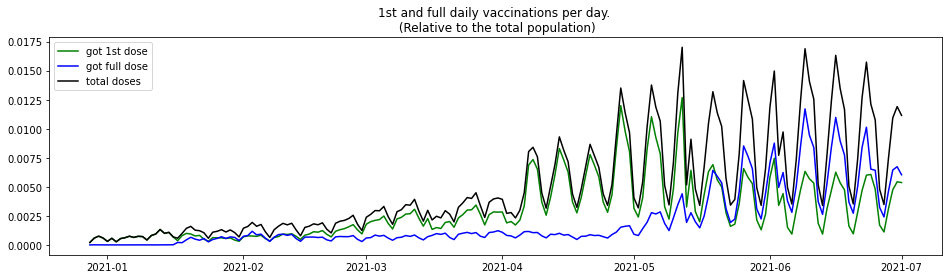

In [62]:
plt.figure('daily vaccinations')
fig = plt.figure(figsize=(16,4))
plt.title('1st and full daily vaccinations per day. \n (Relative to the total population)')
plt.plot(df["date"], df['rel_new_1st'], "-g", label="got 1st dose")
plt.plot(df["date"], df['rel_new_full'], "-b", label="got full dose")
plt.plot(df["date"], df['rel_new_total'], "-k", label="total doses")
plt.legend(loc="upper left")

<Figure size 432x288 with 0 Axes>

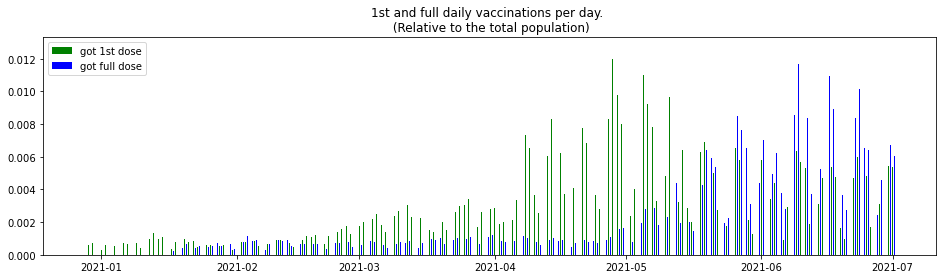

In [63]:
width = 30 / len(df["date"])
next_ = dt.timedelta(hours=12)
plt.figure('daily vaccinations - bar chart')
fig = plt.figure(figsize=(16,4))
plt.title('1st and full daily vaccinations per day. \n (Relative to the total population)')
plt.bar(df["date"], df['rel_new_1st'], color = "g", label="got 1st dose", width=width)
plt.bar(df["date"] + next_, df['rel_new_full'], color = "b", label="got full dose", width=width)
#plt.bar(df["date"], df['rel_new_full'], bottom = df['rel_new_1st'], color = "b", label="got full dose", width=width)
plt.legend(loc="upper left")

### Analysis - how much time is in average between the first and the second dose per vaccine

In [64]:
average_for_days = 31

for vac in ['biontech','moderna','astrazeneca']:
    print(vac)
    df1 = df[['date',vac+'_1_cum']].rename(columns={vac+'_1_cum':vac+'_n'})
    df2 = df[['date',vac+'_2_cum']].rename(columns={vac+'_2_cum':vac+'_n', 'date':'date_2nd'})
    vac_max = df2[vac+'_n'].max()
    print('2nd dose:', round(vac_max/1000000,3))
    dfn = pd.merge_asof(df1[(df1[vac+'_n'] <= vac_max)],df2, on=vac+'_n')
    dfn['2nd_days'] = dfn['date_2nd']-dfn['date']
    average_time_to_2nd_dose = (dfn.iloc[-1-average_for_days:-1]['2nd_days'].mean())#.total_days()
    print(f'average_time_to_2nd_dose last {average_for_days} days       ', average_time_to_2nd_dose)
    average_time_to_2nd_dose_last_14 = (dfn.iloc[-15:-1]['2nd_days'].mean())
    print('average_time_to_2nd_dose_last_14     ', average_time_to_2nd_dose_last_14)
    print(dfn.iloc[-1:,:])    
    print()

biontech
2nd dose: 24.165
average_time_to_2nd_dose last 31 days        35 days 17:01:56.129032
average_time_to_2nd_dose_last_14      33 days 12:00:00
          date  biontech_n   date_2nd 2nd_days
155 2021-05-31    24067897 2021-06-30  30 days

moderna
2nd dose: 2.813
average_time_to_2nd_dose last 31 days        34 days 18:34:50.322580
average_time_to_2nd_dose_last_14      33 days 22:17:08.571428
          date  moderna_n   date_2nd 2nd_days
151 2021-05-27    2768761 2021-06-30  34 days

astrazeneca
2nd dose: 2.553
average_time_to_2nd_dose last 31 days        91 days 19:21:17.419354
average_time_to_2nd_dose_last_14      98 days 15:25:42.857142
         date  astrazeneca_n   date_2nd 2nd_days
88 2021-03-25        2468200 2021-06-30  97 days



### Read pdf - planned deliveries

In [65]:
df_pdf = read_pdf(file_path_deliveries, pages='all')

In [97]:
df_pdf[0].columns = ['NaN','week','biontech','moderna','astrazeneca','johnson']
df_deliveries = df_pdf[0][['week','biontech','moderna','astrazeneca','johnson']].copy()

#df_deliveries = df_pdf[0][['Woche', 'BioNTech', 'Moderna', 'AstraZeneca','Johnson &']].copy()
#df_deliveries.rename(columns={'Woche':'week', 'BioNTech':'biontech', 'Moderna':'moderna', 'AstraZeneca':'astrazeneca','Johnson &':'johnson'},inplace='True')
df_deliveries = df_deliveries[(df_deliveries['week'].str.slice(0,2)=='KW')].fillna(0)
for col in df_deliveries.columns[1:]:
    df_deliveries[col] = np.where(df_deliveries[col] == '-', 0, df_deliveries[col])
    df_deliveries[col] = df_deliveries[col].str.replace('.','').fillna(0)
    df_deliveries[col].replace({'\(':'','\)':''},inplace = True, regex=True)
    df_deliveries[col] = df_deliveries[col].astype(int)
date_end = dt.datetime(2021,1,3)
#df_deliveries['days'] = df_deliveries['week'].str.slice(-2,).astype(int).astype(int)*7
#df_deliveries['week_end'] = df_deliveries['days'].apply(lambda x: date_end + dt.timedelta(days = x))

df_deliveries['week_end'] = df_deliveries['week'].apply(lambda x: date_end + dt.timedelta(days = int(x[-2:])*7))
df_deliveries['week'] = df_deliveries['week'].str.slice(-2).astype(int)
df_deliveries['all_delivered'] = df_deliveries[vacs].sum(axis=1)
#df_deliveries.rename(columns={'astra': 'astrazeneca'},inplace=True)
df_deliveries.reset_index(inplace = True)
del df_deliveries['index']
df_deliveries

,week,biontech,moderna,astrazeneca,johnson,week_end,all_delivered
0,14,2515500,0,249600,0,2021-04-11,2765100
1,15,2515500,40800,614400,256800,2021-04-18,3427500
2,16,2522520,866400,187200,0,2021-04-25,3576120
3,17,3438630,376800,2811700,216600,2021-05-02,6843730
4,18,3407040,550800,0,0,2021-05-09,3957840
5,19,3407040,550800,559200,246000,2021-05-16,4763040
6,20,3408210,550800,465600,295150,2021-05-23,4719760
7,21,3409380,550800,0,724300,2021-05-30,4684480
8,22,5135130,550800,2442000,513600,2021-06-06,8641530
9,23,4585230,550800,561600,240000,2021-06-13,5937630


### assumptions to increase delivery information

In [98]:
#df_deliveries['astrazeneca'].iloc[12:16] = df_deliveries['astrazeneca'].iloc[12:16].mean()
for vac in vacs:
    zero_from = df_deliveries[vac][df_deliveries[vac] != 0].index[-1] + 1
    df_deliveries[vac][zero_from:] = df_deliveries[vac][zero_from - 4 : zero_from].mean()
    df_deliveries[vac] = df_deliveries[vac].astype(int)

<ipython-input-98-81bd99139513>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deliveries[vac][zero_from:] = df_deliveries[vac][zero_from - 4 : zero_from].mean()


### adding new rows to delivery dataframe

In [99]:
additional_rows = 10

In [100]:
for turn in range(additional_rows):
    s = pd.Series(np.zeros(len(df_deliveries.columns)),index = df_deliveries.columns)
    s['week'] = int(df_deliveries['week'].iloc[-1] + 1)
    s['week_end'] = df_deliveries['week_end'].iloc[-1] + dt.timedelta(days = 7)
    for vac in vacs:
        s[vac] = int(df_deliveries[vac].iloc[-4:].mean())
    df_deliveries = df_deliveries.append(s, ignore_index = True)
df_deliveries.week = df_deliveries.week.astype(int)

### parameter for outputs

In [101]:
# number of rows and the end of df_deliveries which do not seem to already have proper numbers:
# cut_rows = 3
cut_rows = df_deliveries[(df_deliveries.biontech == 0)]['biontech'].count()
cut_rows = 1 if (cut_rows == 0) else cut_rows
cut_rows

1

### Minimal reserve (reserve at 11.04.2021 might be even higher the used value)

In [102]:
col_vac_cons = ['date','week','dosen_biontech_kumulativ','dosen_moderna_kumulativ','dosen_astrazeneca_kumulativ','johnson_1_cum']
df_vac_consumption = df_total[col_vac_cons][(df_total['weekday'] == 7)].rename(columns={'johnson_1_cum':'dosen_johnson_kumulativ'}).reset_index()
df_vac_consumption = df_vac_consumption.append(df_total[col_vac_cons].rename(columns={'johnson_1_cum':'dosen_johnson_kumulativ'}).iloc[-1])
for vac in vacs:
    df_vac_consumption[vac+'_consumption'] = (df_vac_consumption['dosen_'+vac+'_kumulativ'] - df_vac_consumption['dosen_'+vac+'_kumulativ'].shift(1))/1000
    #df_vac_consumption = df_vac_consumption.fillna(0)
    #df_vac_consumption[vac+'_consumption'] = df_vac_consumption[vac+'_consumption'].astype(int)
    del df_vac_consumption['dosen_'+vac+'_kumulativ']
df_vac_delta = df_vac_consumption.merge(df_deliveries, 
                                        on = 'week').fillna(0)
for vac in vacs:
    df_vac_delta[vac+'_res_incr'] = df_vac_delta[vac] / 1000 - df_vac_delta[vac+'_consumption']
    df_vac_delta[vac] = (df_vac_delta[vac] / 1000).astype(int)
df_vac_delta = df_vac_delta[['date','week']+[vac+'_res_incr' for vac in vacs]+[vac for vac in vacs]]
for vac in vacs:
    df_vac_delta[vac+'_reserve'] = 0
    for i in df_vac_delta.index:
        if i > 0:
            df_vac_delta.at[i,vac+'_reserve'] = df_vac_delta.at[i-1,vac+'_reserve'] + df_vac_delta.loc[i,vac+'_res_incr']
    #df_vac_delta[vac+'_reserve'] = (df_vac_delta[vac+'_res_incr'] + df_vac_delta[vac+'_reserve'].shift(1)).fillna(0)
    df_vac_delta[vac+'_reserve'] = df_vac_delta[vac+'_reserve'] - df_vac_delta[vac+'_reserve'].min()
df_vac_delta['total_reserve'] = df_vac_delta[[vac+'_reserve' for vac in vacs]].sum(axis=1)
df_vac_delta['total_deliveries'] = df_vac_delta[[vac for vac in vacs]].sum(axis=1)
df_vac_delta[['date','week','total_reserve','total_deliveries']+[vac+'_reserve' for vac in vacs]+[vac for vac in vacs]]

,date,week,total_reserve,total_deliveries,biontech_reserve,moderna_reserve,astrazeneca_reserve,johnson_reserve,biontech,moderna,astrazeneca,johnson
0,2021-04-11,14,1972,2764,891,155,926,0,2515,0,249,0
1,2021-04-18,15,1732,3425,712,0,764,256,2515,40,614,256
2,2021-04-25,16,1788,3575,950,583,0,255,2522,866,187,0
3,2021-05-02,17,3944,6841,436,606,2438,464,3438,376,2811,216
4,2021-05-09,18,2882,3957,317,638,1483,444,3407,550,0,0
5,2021-05-16,19,2690,4762,95,691,1247,657,3407,550,559,246
6,2021-05-23,20,2339,4718,0,646,817,876,3408,550,465,295
7,2021-05-30,21,2245,4683,52,694,214,1285,3409,550,0,724
8,2021-06-06,22,5959,8640,1567,787,2217,1388,5135,550,2442,513
9,2021-06-13,23,5919,5936,1577,780,2387,1175,4585,550,561,240


### Comparrison:
Based on zeit.de information at the 27.06.2021 7 % of the delivered 77.7 mln doses have not been used. I.e. 5.44 mln doses. 
https://www.zeit.de/wissen/gesundheit/corona-impfungen-deutschland-impffortschritt-aktuelle-zahlen-karte.
This figure is in contradiction to the 7.579 mln out of this model. 
And the difference is even bigger since the 7.579 is a lower limit of this figure.

One proplem of this model might be that the real deliveries have been lower then planned and the figures for the past have not been corrected in the delivery-input-file of this model. But an error in the Zeit calculation, which is not transparent, is possible as well.

### Forecast

In [138]:
df_week = df[['date','week']+vac_list_cum + ['all_1','all_full']][(df['weekday'] == 7)].reset_index()

open_1st = vaccination_potential - sum(df_week[[col for col in df_week.columns if col[-6:] == '_1_cum']].iloc[-1])
#print('open_1st', open_1st, 'all_1', df_week['all_1'].iloc[-1], open_1st + df_week['all_1'].iloc[-1])
df_week['open_1st'] = 0
df_week['open_1st'].iloc[-1] = open_1st
open_full = vaccination_potential - sum(df_week[[col for col in df_week.columns if col[-6:] == '_2_cum']].iloc[-1])
#print('open_full', open_full, 'all_full', df_week['all_full'].iloc[-1], open_full + df_week['all_full'].iloc[-1])
df_week['open_full'] = 0
df_week['open_full'].iloc[-1] = open_full
df_week['check_1st'] = np.NaN
df_week['check_full'] = np.NaN
df_week['check_1st'].iloc[-1] = vaccination_potential - df_week['open_1st'].iloc[-1] - df_week['all_1'].iloc[-1]
df_week['check_full'].iloc[-1] = vaccination_potential - df_week['open_full'].iloc[-1] - df_week['all_full'].iloc[-1]

df_week['actuals'] = True
#df_week = df_week[['date','week','actuals'] + [col for col in df_week.columns if col not in ['date','week','actuals']] ]
week_last = df_week['week'].iloc[-1]
#actual_end = df_week.index[-1]
last_actual_index = df_week.index[-1]

for vac in vac_list_cum:
    df_week[vac[:-4]] = df_week[vac]-df_week[vac].shift(1)
df_week = df_week.merge(df_deliveries,how = 'outer', on = 'week')
df_week['actuals'] = df_week['actuals'].fillna(False)

df_week['date'].iloc[10:] = df_week['week'].iloc[10:].apply(lambda x: date_end + dt.timedelta(days = x*7))
df_week = df_week[['date','week','actuals']+vac_list+vacs+vac_list_cum+['all_1','open_1st','check_1st','all_full','open_full','check_full']]

df_week['astra_biontech_2'] = 0
df_week['astra_biontech_2_cum'] = 0
df_week['astra_moderna_2'] = 0
df_week['astra_moderna_2_cum'] = 0

for i in df_week.index:
    if df_week.iloc[i]['week'] > week_last and df_week.iloc[i]['week'] < 52:
        df_week, open_1st, open_full, biontech_rest = vac_dist_to_1_2(df_week, i, open_1st, open_full, 'biontech')
        df_week, open_1st, open_full, moderna_rest = vac_dist_to_1_2(df_week, i, open_1st, open_full, 'moderna')
        #Kreuzimpfungen:
        if astra_biontech_cross:
            astra_biontech_2 = min(biontech_rest, open_full)
            open_full = open_full - astra_biontech_2
            df_week.at[i,'astra_biontech_2'] = astra_biontech_2
            df_week.at[i,'astra_biontech_2_cum'] = df_week.at[i-1,'astra_biontech_2_cum'] + astra_biontech_2
        if astra_moderna_cross:
            astra_moderna_2 = min(biontech_rest, open_full)
            open_full = open_full - astra_moderna_2
            df_week.at[i,'astra_moderna_2'] = astra_moderna_2
            df_week.at[i,'astra_moderna_2_cum'] = df_week.at[i-1,'astra_moderna_2_cum'] + astra_moderna_2
        johnson_1full = min(open_1st,df_week.iloc[i-1]['johnson'])
        df_week.at[i,'johnson_1'] = johnson_1full
        open_1st = open_1st - johnson_1full
        open_full = open_full - johnson_1full
        df_week['johnson_2'] = df_week['johnson_1']
        df_week, open_1st, open_full, astrazeneca_rest = vac_dist_to_1_2(df_week, i, open_1st, open_full, 'astrazeneca')
        for vac in vac_list:
            df_week.at[i, vac+'_cum'] = df_week.at[i - 1, vac+'_cum'] + df_week.at[i, vac]
        df_week.at[i,'all_1'] = sum(df_week[[col for col in df_week.columns if col[-6:] == '_1_cum']].iloc[i])
        df_week.at[i,'all_full'] = sum(df_week[[col for col in df_week.columns if col[-6:] == '_2_cum']].iloc[i])
        
        df_week.at[i,'check_1st'] = vaccination_potential - df_week.at[i,'open_1st'] - df_week.at[i,'all_1']
        df_week.at[i,'check_full'] = vaccination_potential - df_week.at[i,'open_full'] - df_week.at[i,'all_full']

df_week.fillna(0, inplace = True)
df_week = calc_effects(df_week,shift=2)

for col in vac_list + vac_list_cum:
    df_week[col] = df_week[col].astype(int)

df_week['new_1st'] = df_week[[vac + '_1' for vac in vacs]].sum(axis=1)
df_week['new_full'] = df_week[[vac + '_2' for vac in vacs]].sum(axis=1)

df_week.fillna(0)
for col in ['open_full','all_full','new_full','check_full','open_1st','all_1','new_1st','check_1st']:
    df_week[col] = df_week[col].astype(int) 

print('All able and willing may have their 1st dose until: ',df_week['date'][df_week['new_1st'] > 0].iloc[-1].strftime('%d.%m.%y'))
print('All able and willing may have their full dose until: ',df_week['date'][df_week['new_full'] > 0].iloc[-1].strftime('%d.%m.%y'))
# index_full_vaccinated
end_vaccination = df_week.index[df_week['open_full'] > 0][-1]+1
end_1st_vaccination = df_week.index[df_week['open_1st'] > 0][-1]+1

All able and willing may have their 1st dose until:  01.08.21
All able and willing may have their full dose until:  12.09.21


/home/thomas/python/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [139]:
"""df_week[['date', 'week', 'actuals', 'biontech_1', 'biontech_2', 'moderna_1',
       'moderna_2', 'astrazeneca_1', 'astrazeneca_2', 'johnson_1', 'johnson_2', 'astra_biontech_2_cum',
       'biontech', 'moderna', 'astrazeneca', 'johnson', 'biontech_1_cum',
       'biontech_2_cum', 'moderna_1_cum', 'moderna_2_cum', 'astrazeneca_1_cum',
       'astrazeneca_2_cum', 'johnson_1_cum', 'johnson_2_cum', 'all_1',
       'new_1st','open_1st', 'check_1st', 'all_full', 'new_full','open_full', 'check_full']].iloc[last_actual_index-2:end_vaccination+3]"""
print()

### Overview table about the most important current and future developments

In [140]:
"""df_week[['date', 'week', 'actuals', 'open_full', 'all_full','new_full', 'check_full', 'open_1st', 'all_1', 'new_1st', 'check_1st','rel_new_1st', 
         'rel_new_full', 'rel_new_total']].iloc[last_actual_index-2:]"""
# for output rows:
future_weeks = 5
#table_until = last_actual_index+future_weeks
table_until = end_vaccination + 1

df_week[['date','week','actuals','rel_new_total','rel_new_1st','rel_new_full','rel_all_1','rel_all_full','rel_net_effect', \
         'R_to_1','rel_net_effect_after_14','R_to_1_14','rel_biontech_14']].iloc[last_actual_index-2:table_until]

,date,week,actuals,rel_new_total,rel_new_1st,rel_new_full,rel_all_1,rel_all_full,rel_net_effect,R_to_1,rel_net_effect_after_14,R_to_1_14,rel_biontech_14
24,2021-06-13,23,True,0.071,0.027,0.049,0.484,0.265,0.365,1.575,0.417,1.716,0.702
25,2021-06-20,24,True,0.070,0.026,0.048,0.510,0.312,0.390,1.639,0.444,1.797,0.703
26,2021-06-27,25,True,0.066,0.027,0.042,0.537,0.354,0.417,1.716,0.470,1.887,0.708
27,2021-07-04,26,False,0.079,0.056,0.025,0.593,0.380,0.444,1.797,0.519,2.077,0.726
28,2021-07-11,27,False,0.108,0.081,0.039,0.674,0.419,0.470,1.887,0.585,2.411,0.723
29,2021-07-18,28,False,0.072,0.042,0.031,0.717,0.449,0.519,2.077,0.621,2.639,0.714
30,2021-07-25,29,False,0.072,0.048,0.024,0.764,0.473,0.585,2.411,0.661,2.949,0.701
31,2021-08-01,30,False,0.068,0.037,0.033,0.801,0.507,0.621,2.639,0.693,3.254,0.697
32,2021-08-08,31,False,0.046,0.000,0.046,0.801,0.553,0.661,2.949,0.696,3.294,0.697
33,2021-08-15,32,False,0.050,0.000,0.050,0.801,0.602,0.693,3.254,0.703,3.362,0.698


### Most relevant summary and plots with new and total vaccinations

In [141]:
graph_until = end_vaccination + 2
df_plot = df_week[:graph_until]
date_every_1st = df_plot['date'].iloc[end_1st_vaccination].strftime('%d.%m.%y')
date_every_full = df_plot['date'].iloc[end_vaccination].strftime('%d.%m.%y')

In [142]:
graph_until = end_vaccination + 2
df_plot = df_week[:graph_until]
date_every_1st = df_plot['date'].iloc[end_1st_vaccination].strftime('%d.%m.%y')
date_every_full = df_plot['date'].iloc[end_vaccination].strftime('%d.%m.%y')
max_efficacy_reached = (df_plot['date'].iloc[end_vaccination]+dt.timedelta(days=14)).strftime('%d.%m.%y')
max_efficacy = round(df_plot['rel_net_effect_after_14'].iloc[end_vaccination],3)
max_R_to_1 = round(df_plot['R_to_1_14'].iloc[end_vaccination],3)

result_string = f'Based on the integrated implementation of how many people are able (in this run based on the \n \
age: {minimum_age_for_vac_implemented}) and willing to get the vaccination (currently implemented: {population_willing_of_able}), \n \
there is a relative vaccination potential of {rel_vaccination_potential} for the German population. \n \
Based on this percentage and the assumed vaccine deliveries the model generates the following \n \
forecast: \n \
\n \
At the {date_every_1st} everyone who is able and willing will have his or her 1st vaccination. \n \
At the {date_every_full} everyone who is able and willing will have his/her full vaccination. \n \
At the {max_efficacy_reached} the maximum relative immunity is reached with {max_efficacy}. \n \
Simultanously at the {max_efficacy_reached} a R-value of {max_R_to_1} is reduced to 1.'

path = os.path.join(result_folder,'summary_text.txt')
print(result_string, file=open(path,'wt'))

# Saving result text as a white image with text for the import to markup
from PIL import Image, ImageFont, ImageDraw
img = Image.new('RGB', (900, 160), color = (255,255,255))
fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 15)
ImageDraw.Draw(img).text((0,0), result_string, font=fnt, fill=(0,0,0))
img.save(os.path.join(result_folder,'result_text.jpg'))

Based on the integrated implementation of how many people are able (in this run based on the 
 age: 12) and willing to get the vaccination (currently implemented: 0.9), 
 there is a relative vaccination potential of 0.80145 for the German population. 
 Based on this percentage and the assumed vaccine deliveries the model generates the following 
 forecast: 
 
 At the 01.08.21 everyone who is able and willing will have his or her 1st vaccination. 
 At the 12.09.21 everyone who is able and willing will have his/her full vaccination. 
 At the 26.09.21 the maximum relative immunity is reached with 0.728. 
 Simultanously at the 26.09.21 a R-value of 3.677 is reduced to 1.


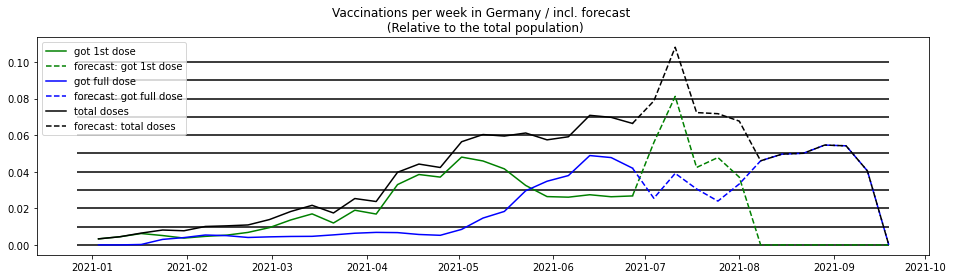

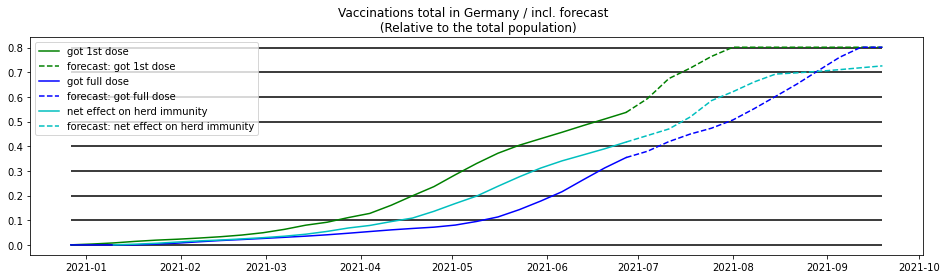

In [143]:
plt.figure('weekly vaccinations',figsize=(16,4))
#plt.subplot(2,2,1)
plt.title('Vaccinations per week in Germany / incl. forecast \n (Relative to the total population)')
plt.hlines(np.array(range(ceil(df_plot['rel_new_total'].max()*100)))/100,df_plot["date"][0],df_plot["date"].iloc[-1])
plt.plot(df_plot["date"][:last_actual_index+1], df_plot['rel_new_1st'][:last_actual_index+1], "-g", ls="-", label="got 1st dose")
plt.plot(df_plot["date"][last_actual_index:graph_until], df_plot['rel_new_1st'][last_actual_index:graph_until], "-g", ls="--", label="forecast: got 1st dose")
plt.plot(df_plot["date"][:last_actual_index+1], df_plot['rel_new_full'][:last_actual_index+1], "-b", ls="-", label="got full dose")
plt.plot(df_plot["date"][last_actual_index:graph_until], df_plot['rel_new_full'][last_actual_index:graph_until], "-b", ls="--", label="forecast: got full dose")
plt.plot(df_plot["date"][:last_actual_index+1], df_plot['rel_new_total'][:last_actual_index+1], "-k", ls="-", label="total doses")
plt.plot(df_plot["date"][last_actual_index:graph_until], df_plot['rel_new_total'][last_actual_index:graph_until], "-k", ls="--", label="forecast: total doses")
plt.legend(loc="upper left")
plt.savefig(os.path.join(result_folder,'vaccinations_per_week'))

plt.figure('weekly total',figsize=(16,4))
#plt.subplot(2,2,2)
plt.title('Vaccinations total in Germany / incl. forecast  \n (Relative to the total population)')
plt.hlines(np.array(range(ceil(df_plot['rel_all_1'].max()*10)))/10,df_plot["date"][0],df_plot["date"].iloc[-1])
plt.plot(df_plot["date"][:last_actual_index+1], df_plot['rel_all_1'][:last_actual_index+1], "-g", ls="-", label="got 1st dose")
plt.plot(df_plot["date"][last_actual_index:graph_until], df_plot['rel_all_1'][last_actual_index:graph_until], "-g", ls="--", label="forecast: got 1st dose")
plt.plot(df_plot["date"][:last_actual_index+1], df_plot['rel_all_full'][:last_actual_index+1], "-b", ls="-", label="got full dose")
plt.plot(df_plot["date"][last_actual_index:graph_until], df_plot['rel_all_full'][last_actual_index:graph_until], "-b", ls="--", label="forecast: got full dose")
plt.plot(df_plot["date"][:last_actual_index+1], df_plot['rel_net_effect'][:last_actual_index+1], "-c", ls="-", label="net effect on herd immunity")
plt.plot(df_plot["date"][last_actual_index:graph_until if cut_rows > 0 else -1], df_plot['rel_net_effect'][last_actual_index:graph_until if cut_rows > 0 else -1], "-c", ls="--", label="forecast: net effect on herd immunity")
plt.legend(loc="upper left")
plt.savefig(os.path.join(result_folder,'vaccinations_total'))

print(result_string)

### Relevant information for beginning of July - the time for which a useful delivery forecast is available 

In [144]:
print('date: ',df_plot.date.iloc[-cut_rows])
print('1st dose: ',round(df_plot['all_1'].iloc[-cut_rows]/1000000,3),'mln')
print('Full dose: ',round(df_plot['all_full'].iloc[-cut_rows]/1000000,3),'mln')
print('1st dose working: ',round(df_plot['all_1'].iloc[-cut_rows]/1000000,3),'mln')
print('Full dose working: ',round(df_plot['all_full'].iloc[-cut_rows]/1000000,3),'mln')
print()

rel_net_effect = round(df_plot['net_effect'].iloc[-cut_rows] / df_plot['all_1'].iloc[-cut_rows],3)
print(f'The current net effect per person with current 1st dose is {rel_net_effect}')
rel_net_effect_2nd = round(df_plot['net_effect_2nd'].iloc[-cut_rows] / df_plot['all_full'].iloc[-cut_rows],3)
print(f'The current net effect per person with current 2nd dose is {rel_net_effect_2nd}')
current_real_net = round(df_plot['rel_net_effect'].iloc[-cut_rows],3)
print(f'The current relative net effect on the population is ',current_real_net)
R_to_1 = round(1 / (1-current_real_net),3)
print(f'A R-rate of {R_to_1} is reduced to one due to the vaccination')
real_net_14 = round(df_plot['rel_net_effect_after_14'].iloc[-cut_rows],3)
date_14 = df_plot.date.iloc[-cut_rows] + dt.timedelta(days = 14)
print(f'The relative net effect in 14 days ({date_14}) on the population is ',real_net_14)
R_to_1_14 = round(1 / (1-real_net_14),3)
print(f'In 14 days at the {date_14} a R-rate of {R_to_1_14} is reduced to 1.0 due to the vaccination')

date:  2021-09-19 00:00:00
1st dose:  66.6 mln
Full dose:  66.6 mln
1st dose working:  66.6 mln
Full dose working:  66.6 mln

The current net effect per person with current 1st dose is 0.906
The current net effect per person with current 2nd dose is 0.848
The current relative net effect on the population is  0.726
A R-rate of 3.65 is reduced to one due to the vaccination
The relative net effect in 14 days (2021-10-03 00:00:00) on the population is  0.728
In 14 days at the 2021-10-03 00:00:00 a R-rate of 3.676 is reduced to 1.0 due to the vaccination
